In [144]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [145]:
N_SAMPLES = 1000
TEST_SIZE = 0.1


#X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X, y = make_circles(n_samples = N_SAMPLES, noise=0.02, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [146]:
#X_train = X_train.reshape(X_train.shape[1], X_train.shape[0])
#X = X.reshape(X.shape[1], X.shape[0])
#y_train = y_train.reshape((y_train.shape[0], 1))

In [147]:
def init_layers(nn_architecture, seed=99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values

In [148]:
#params_values = init_layers(nn_architecture=nn_architecture)

In [149]:
#params_values

In [150]:
'''print(params_values["W1"])
dropout_percent = 0.25
shape = params_values["W1"].shape
print(shape)
print(np.ones(shape))

params_values["W1"] *= np.random.binomial([np.ones((shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
print(params_values["W1"])'''

'print(params_values["W1"])\ndropout_percent = 0.25\nshape = params_values["W1"].shape\nprint(shape)\nprint(np.ones(shape))\n\nparams_values["W1"] *= np.random.binomial([np.ones((shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))\nprint(params_values["W1"])'

In [151]:
#np.random.binomial([np.ones((shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))

In [152]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [153]:
def relu(Z):
    return np.maximum(0, Z)

In [154]:
def mish(Z):
    return Z * np.tanh(np.log(1+np.exp(Z)))

In [155]:
def sigmoid_backwards(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

In [156]:
def relu_backwards(dA, Z):
    #print("relu backwards shape")
    #print(dA.shape, Z.shape)
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [157]:
def mish_backwards(dA, Z):
    w = 4*(Z+1) + 4 * np.exp(2*Z) + np.exp(3*Z) + np.exp(Z)*(4*Z + 6)
    d = 2*np.exp(Z) + np.exp(2*Z) + 2
    return dA * (np.exp(Z) * w)/ (d**2)

In [158]:
def single_layer_forward_prop(A_prev, W_curr, b_curr, activation = "relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    Z_curr = np.nan_to_num(Z_curr)

    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "mish":
        activation_func = mish
    else:
        raise Exception('Non supported activation function')
        
    A_curr = activation_func(Z_curr)

    return A_curr, Z_curr

In [159]:
def full_forward_prop(X, params_values, nn_architecture, dropout=True):
    memory = {}
    A_curr = X
    dropout_perc = 0.4

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_func_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
       
        b_curr = params_values["b" + str(layer_idx)]
        
        A_curr, Z_curr = single_layer_forward_prop(A_prev, W_curr, b_curr, activ_func_curr)
                       
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    return A_curr, memory

In [160]:
#full_forward_prop(X=X_train, params_values=params_values, nn_architecture=nn_architecture)

In [161]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1/m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1-Y, np.log(1-Y_hat).T))
    return np.squeeze(cost)

def get_accuracy(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return(Y_hat_ == Y).all(axis=0).mean()

In [162]:
def single_layer_back_prop(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """
    Implements dZ[l] = dA[l] * g' * (Z[l])
    This is the backprop for one layer
    
    """
    
    # number of examples
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_act_func = relu_backwards
    elif activation is "sigmoid":
        backward_act_func = sigmoid_backwards
    elif activation is "mish":
        backward_act_func = mish_backwards
    else:
        raise Exception('Not supported activation function')
    
    # calculate derivative of activation function
    dZ_curr = backward_act_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    #print("dW_curr = ",  dW_curr)
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

In [163]:
def full_backward_prop(Y_hat, Y, memory, params_values, nn_architecture, dropout=True, dropout_percent = 0.2):
    """
    Find gradients -((Y/Y_hat) - ((1-Y)/(1-Y_hat))) = dY_hat
    """
    grad_values = {}
    
    # number of examples
    m = Y.shape
    Y = Y.reshape(Y_hat.shape)
    Y_hat[Y_hat == 0] = 0.00001
    
    dA_prev = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    
    #if dropout:
        #shape = params_values["W1"].shape
        #params_values["W1"] *= np.random.binomial([np.ones((shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
   
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # We extract all the parameters for each layer
        layer_idx_curr = layer_idx_prev + 1
        #print(layer_idx_curr)
        
        activation_func_curr = layer['activation']
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        #print("Z curr shape is")
        #print(Z_curr.shape)
        #if layer_idx_curr == 1:
            #if dropout:
                #Z_curr *= np.random.binomial([np.ones((Z_curr.shape))], 1-dropout_percent)[0] * (1.0/1-dropout_percent)
                #print("Z_curr = ", Z_curr)
        if dropout:
            Z_curr *= np.random.binomial([np.ones((Z_curr.shape))], 1-dropout_percent)[0] * (1.0/1-dropout_percent)
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        W_curr = np.nan_to_num(W_curr)
        b_curr = np.nan_to_num(b_curr)
        
        
        # run single layer backprop and update grad_values
        
        dA_prev, dW_curr, db_curr = single_layer_back_prop(dA_curr, 
                                                           W_curr, b_curr, Z_curr,
                                                           A_prev, activation_func_curr)
        dW_curr = np.nan_to_num(dW_curr)
        db_curr = np.nan_to_num(db_curr)
        
        grad_values["dW" + str(layer_idx_curr)] = dW_curr
        grad_values["db" + str(layer_idx_curr)] = db_curr
        
    return grad_values    

In [164]:
def update(params_values, grad_values, nn_architecture, learning_rate):
    for idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(idx)] -= np.nan_to_num(learning_rate * grad_values["dW" + str(idx)])
        params_values["b" + str(idx)] -= np.nan_to_num(learning_rate * grad_values["db" + str(idx)])
    return params_values
    

In [93]:
#update(params_values, grad_values, nn_architecture, 0.01)

In [94]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim":25, "output_dim": 1, "activation": "sigmoid"},
] # @ lr=0.1 starts getting better at 1370-1371

In [165]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 25, "activation": "mish"},
    {"input_dim": 25, "output_dim": 50, "activation": "mish"},
    {"input_dim": 50, "output_dim": 50, "activation": "mish"},
    {"input_dim": 50, "output_dim": 25, "activation": "mish"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
] 

In [ ]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
   
]

In [83]:
def train(X_train, y_train, nn_architecture, params, epochs = 1000, learning_rate = 0.03, dropout=True, dropout_percent = 0.2):
    if params == 0:
        params_values = init_layers(nn_architecture)
    else:
        params_values = params
    #print("initial params values = \n")
    #print(params_values)
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        # forward prop
        y_hat, memory = full_forward_prop(X_train, params_values, nn_architecture)
        #print(memory)
        #print("y_hat = ", y_hat)
        y_hat[y_hat == 0] = 0.01
        
        # Calc loss
        cost = get_cost_value(y_hat, y_train)
        if cost == np.nan:
            print("stop")
            break
        cost_history.append(cost)
        
        accuracy = get_accuracy(y_hat, y_train)
        accuracy_history.append(accuracy)
        
        
        # Back prop!
        
        grad_values = full_backward_prop(y_hat, y_train, memory, 
                                         params_values, nn_architecture, 
                                         dropout=dropout, dropout_percent=dropout_percent)
        #print("\nGradValues\n")
        #print(grad_values)
        #if i == 0:
            #print(grad_values["dW"+str(1)])
            #print("dropout_percent = ", dropout_percent)
        
        params_values = update(grad_values=grad_values, params_values=params_values,
                              nn_architecture=nn_architecture, learning_rate=learning_rate)
        
        if(i%100==0):
            #print(i)
            learning_rate = learning_rate * 0.995
            print('iter : {:.0f} accuracy : {:.4f} - cost : {:.4f} - learning rate : {:.4f}'.format(i, accuracy, cost, learning_rate))
            
        
        
        

    
    return params_values, y_hat, memory, grad_values, accuracy_history, cost_history

In [84]:
#grad_values["dW"+str(1)]

In [81]:
params_values

NameError: name 'params_values' is not defined

In [100]:
# Training
params_values, y_hat, memory, grad_values, accuracy_history, cost_history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), 
                                                                                  nn_architecture, 0, 20000, 0.3, dropout=True, dropout_percent = 0.4)

iter : 0 accuracy : 0.5044 - cost : 0.6943 - learning rate : 0.2985
iter : 100 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2970
iter : 200 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2955
iter : 300 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2940
iter : 400 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2926
iter : 500 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2911
iter : 600 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2897
iter : 700 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2882
iter : 800 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2868
iter : 900 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2853
iter : 1000 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2839
iter : 1100 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2825
iter : 1200 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2811
iter : 1300 accuracy : 0.5044 - cost : 0.6931 - learning rate : 0.2797
iter : 1400 accura

C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in tanh
  
C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWa

iter : 7200 accuracy : 0.5044 - cost : nan - learning rate : 0.2081
iter : 7300 accuracy : 0.5044 - cost : nan - learning rate : 0.2070
iter : 7400 accuracy : 0.5044 - cost : nan - learning rate : 0.2060
iter : 7500 accuracy : 0.5044 - cost : nan - learning rate : 0.2050
iter : 7600 accuracy : 0.5044 - cost : nan - learning rate : 0.2039
iter : 7700 accuracy : 0.5044 - cost : nan - learning rate : 0.2029
iter : 7800 accuracy : 0.5044 - cost : nan - learning rate : 0.2019
iter : 7900 accuracy : 0.5044 - cost : nan - learning rate : 0.2009


KeyboardInterrupt: 

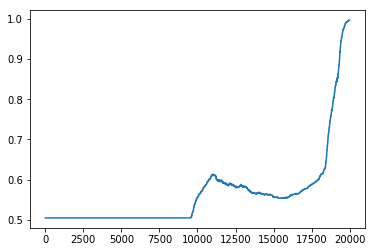

In [72]:
plt.plot(accuracy_history);

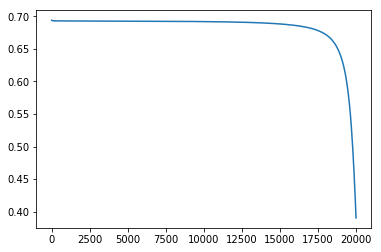

In [73]:
plt.plot(cost_history);

In [74]:
params_values

{'W1': array([[-0.31328146,  0.83942515],
        [ 0.06964472,  0.28147817],
        [-0.2823877 ,  0.01123861],
        [ 0.11593062,  0.40616073],
        [-0.38015382, -1.23564989],
        [-0.01670494,  0.0685398 ],
        [-0.09852897,  0.3759462 ],
        [-0.09074587, -0.65161465],
        [ 0.09071277, -0.08840569],
        [-0.00780754,  0.10357589],
        [-0.62689294,  0.14812234],
        [-0.04796893, -0.00976217],
        [-0.03734863, -0.0461971 ],
        [-0.46214648,  0.00193224],
        [-0.08195591,  0.48357759],
        [-0.3240049 , -0.04498286],
        [ 1.16464432,  0.68567918],
        [ 0.06077042,  0.14898323],
        [-0.38572955, -0.17013448],
        [-0.84624007,  0.50141452],
        [ 0.75474065, -0.21706762],
        [ 0.72709771, -0.55819818],
        [-0.11919342,  0.05527319],
        [-0.17746895, -0.20986626],
        [ 0.27648084, -0.50232706]]), 'b1': array([[ 0.00782597],
        [-0.07958885],
        [-0.02329054],
        [-0.117134

In [75]:
grad_values

{'dW5': array([[ 4.19453792e-02,  1.67933402e-02, -1.88337019e-02,
         -1.87494533e-02,  2.00523844e-03,  6.18146538e-03,
         -1.11565131e-02, -3.04006877e-03,  1.92704553e-03,
          9.17854655e-03,  2.39192548e-03, -7.25273202e-03,
         -1.57025493e-02,  7.14862703e-03,  7.36664963e-03,
          2.85470471e-02, -1.27498401e-02,  9.51898665e-05,
          4.58086102e-03,  1.74033266e-02,  2.13930836e-03,
          1.38948350e-02,  3.08883737e-03,  5.70534596e-02,
          2.43330273e-02]]),
 'db5': array([[-0.04551343]]),
 'dW4': array([[-2.85248157e-03, -4.62586220e-05, -2.60021940e-03, ...,
          4.07012775e-03,  7.37187294e-03,  0.00000000e+00],
        [-8.99854320e-04, -1.67384347e-05, -7.83457925e-04, ...,
          1.70208818e-03,  3.06242556e-03,  0.00000000e+00],
        [-3.99274221e-04,  1.25025248e-05, -4.46838823e-04, ...,
         -2.32768317e-03, -4.03786321e-03,  0.00000000e+00],
        ...,
        [-4.60847739e-06, -3.20096106e-07, -2.97004474

In [ ]:
y_train.shape

In [ ]:
y_hat

In [ ]:
m = y_hat.shape[1]
cost = -1/m * (np.dot(y_train, np.log(y_hat).T) + np.dot(1-y_train, np.log(1-y_hat).T))
np.squeeze(cost)

In [ ]:
y_train

In [ ]:
y_hat

In [ ]:
sum(y_train)

In [ ]:
454/900

In [ ]:
for idx, i in reversed(list(enumerate(nn_architecture))):
    print(idx)
    print(i)

In [ ]:
i['activation']

In [ ]:
for idx, i in enumerate(memory):
    print(memory[i])

In [ ]:
memory

In [ ]:
relu(-3), relu(3)

In [ ]:
nn_architecture

In [ ]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [ ]:
make_plot(X_train, y_train, "Dataset")

In [ ]:
import numpy as np
X = np.array([ [0,0,1],[0,1,1],[1,0,1],[1,1,1] ])
y = np.array([[0,1,1,0]]).T
alpha,hidden_dim,dropout_percent,do_dropout = (0.5,4,0.2,True)
synapse_0 = 2*np.random.random((3,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,1)) - 1
for j in range(3):
    layer_1 = (1/(1+np.exp(-(np.dot(X,synapse_0)))))
    print(layer_1)
    if(do_dropout):
        layer_1 *= np.random.binomial([np.ones((len(X),hidden_dim))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
    print(layer_1)
    layer_2 = 1/(1+np.exp(-(np.dot(layer_1,synapse_1))))
    layer_2_delta = (layer_2 - y)*(layer_2*(1-layer_2))
    layer_1_delta = layer_2_delta.dot(synapse_1.T) * (layer_1 * (1-layer_1))
    synapse_1 -= (alpha * layer_1.T.dot(layer_2_delta))
    synapse_0 -= (alpha * X.T.dot(layer_1_delta))

In [ ]:
X = np.array([ [0,0,1],[0,1,1],[1,0,1],[1,1,1] ])

In [ ]:
X

In [ ]:
len(X)

In [ ]:
# KERAS

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

C:\Users\dsloetto\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [50]:
def mish_keras(Z):
    return Z * keras.backend.tanh(keras.backend.log(1+keras.backend.exp(Z)))

In [51]:
X, y = make_circles(n_samples = N_SAMPLES, noise=0.02, random_state=100)
#X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [52]:
# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X, y, epochs=500, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
1000/1000 [==============================] - 1s 702us/step - loss: 0.7004 - acc: 0.4930
Epoch 2/500
1000/1000 [==============================] - 0s 96us/step - loss: 0.6990 - acc: 0.4930
Epoch 3/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.6978 - acc: 0.4680
Epoch 4/500
1000/1000 [==============================] - 0s 82us/step - loss: 0.6968 - acc: 0.4400
Epoch 5/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.6962 - acc: 0.4700
Epoch 6/500
1000/1000 [==============================] - 0s 79us/step - loss: 0.6957 - acc: 0.4640
Epoch 7/500
1000/1000 [==============================] - 0s 75us/step - loss: 0.6952 - acc: 0.4630
Epoch 8/500
1000/1000 [==============================] - 0s 86us/step - loss: 0.6948 - acc: 0.4400
Epoch 9/500
1000/1000 [==============================] - 0s 88us/step - loss: 0.6945 - acc: 0.3830
Epoch 10/500
1000/1000 [==============================] - 0s

1000/1000 [==============================] - 0s 78us/step - loss: 0.0411 - acc: 1.0000
Epoch 160/500
1000/1000 [==============================] - 0s 72us/step - loss: 0.0392 - acc: 1.0000
Epoch 161/500
1000/1000 [==============================] - 0s 73us/step - loss: 0.0373 - acc: 1.0000
Epoch 162/500
1000/1000 [==============================] - 0s 82us/step - loss: 0.0357 - acc: 1.0000
Epoch 163/500
1000/1000 [==============================] - 0s 85us/step - loss: 0.0342 - acc: 1.0000
Epoch 164/500
1000/1000 [==============================] - 0s 91us/step - loss: 0.0328 - acc: 1.0000
Epoch 165/500
1000/1000 [==============================] - 0s 78us/step - loss: 0.0314 - acc: 1.0000
Epoch 166/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.0302 - acc: 1.0000
Epoch 167/500
1000/1000 [==============================] - 0s 100us/step - loss: 0.0290 - acc: 1.0000
Epoch 168/500
1000/1000 [==============================] - 0s 80us/step - loss: 0.0279 - acc: 1.0000
Ep

1000/1000 [==============================] - 0s 89us/step - loss: 0.0026 - acc: 1.0000
Epoch 320/500
1000/1000 [==============================] - 0s 71us/step - loss: 0.0026 - acc: 1.0000
Epoch 321/500
1000/1000 [==============================] - 0s 80us/step - loss: 0.0025 - acc: 1.0000
Epoch 322/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.0025 - acc: 1.0000
Epoch 323/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.0025 - acc: 1.0000
Epoch 324/500
1000/1000 [==============================] - 0s 83us/step - loss: 0.0025 - acc: 1.0000
Epoch 325/500
1000/1000 [==============================] - 0s 91us/step - loss: 0.0025 - acc: 1.0000
Epoch 326/500
1000/1000 [==============================] - 0s 99us/step - loss: 0.0024 - acc: 1.0000
Epoch 327/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.0024 - acc: 1.0000
Epoch 328/500
1000/1000 [==============================] - 0s 82us/step - loss: 0.0024 - acc: 1.0000
Epoc

1000/1000 [==============================] - 0s 74us/step - loss: 0.0011 - acc: 1.0000
Epoch 480/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.0011 - acc: 1.0000
Epoch 481/500
1000/1000 [==============================] - 0s 96us/step - loss: 0.0011 - acc: 1.0000
Epoch 482/500
1000/1000 [==============================] - 0s 78us/step - loss: 0.0011 - acc: 1.0000
Epoch 483/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.0011 - acc: 1.0000
Epoch 484/500
1000/1000 [==============================] - 0s 76us/step - loss: 0.0011 - acc: 1.0000
Epoch 485/500
1000/1000 [==============================] - 0s 87us/step - loss: 0.0011 - acc: 1.0000
Epoch 486/500
1000/1000 [==============================] - 0s 101us/step - loss: 0.0011 - acc: 1.0000
Epoch 487/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.0011 - acc: 1.0000
Epoch 488/500
1000/1000 [==============================] - 0s 114us/step - loss: 0.0011 - acc: 1.0000
Ep

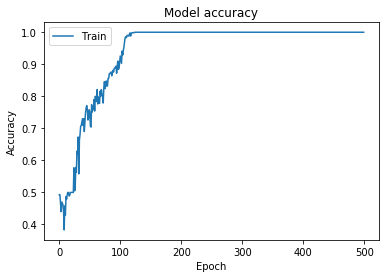

In [54]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [55]:
# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation=mish_keras))
model.add(Dense(50, activation=mish_keras))
model.add(Dense(50, activation=mish_keras))
model.add(Dense(25, activation=mish_keras))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_7 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 26        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
_________________________________________________________________


In [56]:
history2 = model.fit(X, y, epochs=500, verbose=1)

Epoch 1/500
1000/1000 [==============================] - 1s 949us/step - loss: 0.6936 - acc: 0.4920
Epoch 2/500
1000/1000 [==============================] - 0s 92us/step - loss: 0.6936 - acc: 0.4930
Epoch 3/500
1000/1000 [==============================] - 0s 91us/step - loss: 0.6935 - acc: 0.4940
Epoch 4/500
1000/1000 [==============================] - 0s 97us/step - loss: 0.6936 - acc: 0.4970
Epoch 5/500
1000/1000 [==============================] - 0s 95us/step - loss: 0.6935 - acc: 0.4950
Epoch 6/500
1000/1000 [==============================] - 0s 96us/step - loss: 0.6935 - acc: 0.4940
Epoch 7/500
1000/1000 [==============================] - 0s 129us/step - loss: 0.6934 - acc: 0.4890
Epoch 8/500
1000/1000 [==============================] - 0s 86us/step - loss: 0.6934 - acc: 0.4990
Epoch 9/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.6934 - acc: 0.5060
Epoch 10/500
1000/1000 [==============================] - 0s 87us/step - loss: 0.6934 - acc: 0.4980
Epoch 1

1000/1000 [==============================] - 0s 82us/step - loss: 0.6871 - acc: 0.6750
Epoch 162/500
1000/1000 [==============================] - 0s 90us/step - loss: 0.6870 - acc: 0.6690
Epoch 163/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.6869 - acc: 0.6580
Epoch 164/500
1000/1000 [==============================] - 0s 83us/step - loss: 0.6868 - acc: 0.6030
Epoch 165/500
1000/1000 [==============================] - 0s 85us/step - loss: 0.6867 - acc: 0.6860
Epoch 166/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.6866 - acc: 0.6800
Epoch 167/500
1000/1000 [==============================] - 0s 106us/step - loss: 0.6865 - acc: 0.6860
Epoch 168/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.6864 - acc: 0.6740
Epoch 169/500
1000/1000 [==============================] - 0s 86us/step - loss: 0.6863 - acc: 0.6840
Epoch 170/500
1000/1000 [==============================] - 0s 86us/step - loss: 0.6862 - acc: 0.6660
Ep

1000/1000 [==============================] - 0s 116us/step - loss: 0.1177 - acc: 1.0000
Epoch 322/500
1000/1000 [==============================] - 0s 90us/step - loss: 0.1074 - acc: 0.9990
Epoch 323/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.0985 - acc: 1.0000
Epoch 324/500
1000/1000 [==============================] - 0s 89us/step - loss: 0.0901 - acc: 1.0000
Epoch 325/500
1000/1000 [==============================] - 0s 87us/step - loss: 0.0838 - acc: 1.0000
Epoch 326/500
1000/1000 [==============================] - 0s 99us/step - loss: 0.0770 - acc: 1.0000
Epoch 327/500
1000/1000 [==============================] - 0s 89us/step - loss: 0.0713 - acc: 1.0000
Epoch 328/500
1000/1000 [==============================] - 0s 105us/step - loss: 0.0662 - acc: 1.0000
Epoch 329/500
1000/1000 [==============================] - 0s 124us/step - loss: 0.0610 - acc: 1.0000
Epoch 330/500
1000/1000 [==============================] - 0s 102us/step - loss: 0.0568 - acc: 1.0000


1000/1000 [==============================] - 0s 80us/step - loss: 0.0021 - acc: 1.0000
Epoch 482/500
1000/1000 [==============================] - 0s 80us/step - loss: 0.0021 - acc: 1.0000
Epoch 483/500
1000/1000 [==============================] - 0s 79us/step - loss: 0.0020 - acc: 1.0000
Epoch 484/500
1000/1000 [==============================] - 0s 82us/step - loss: 0.0020 - acc: 1.0000
Epoch 485/500
1000/1000 [==============================] - 0s 76us/step - loss: 0.0020 - acc: 1.0000
Epoch 486/500
1000/1000 [==============================] - 0s 113us/step - loss: 0.0020 - acc: 1.0000
Epoch 487/500
1000/1000 [==============================] - 0s 93us/step - loss: 0.0020 - acc: 1.0000
Epoch 488/500
1000/1000 [==============================] - 0s 81us/step - loss: 0.0019 - acc: 1.0000
Epoch 489/500
1000/1000 [==============================] - 0s 82us/step - loss: 0.0019 - acc: 1.0000
Epoch 490/500
1000/1000 [==============================] - 0s 83us/step - loss: 0.0019 - acc: 1.0000
Epo

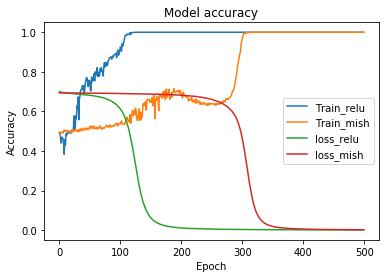

In [57]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_relu', 'Train_mish', 'loss_relu', 'loss_mish'], loc='best')
plt.show()

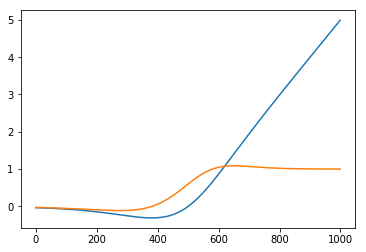

In [67]:
X = np.arange(-5, 5, 0.01)
plt.plot(mish(X))
plt.plot(mish_backwards(X, X))
plt.show();

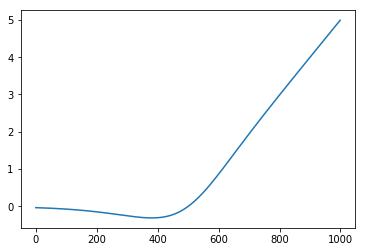

In [68]:
plt.plot(mish(X))

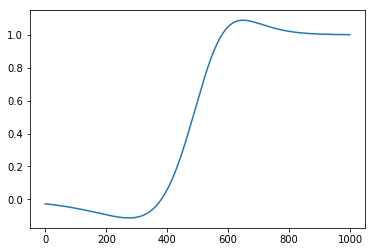

In [69]:
plt.plot(mish_backwards(X, X))

In [101]:
# Samples from X_train

In [198]:
X_train.shape[0]/100

9.0

In [167]:
randomRows = np.random.randint(X_train.shape[0], size=int(X_train.shape[0]/100))
print(randomRows)

[569 836 798 207 887  11 578 342 620]


In [168]:
X_train[randomRows]

array([[ 0.1944106 , -0.79841751],
       [ 0.20878402,  0.79769885],
       [-0.69660651,  0.41658266],
       [ 0.96566283,  0.23583416],
       [ 1.00634737,  0.01022937],
       [ 0.7239096 ,  0.65414066],
       [ 0.95571593, -0.25876272],
       [-0.40108425,  0.67811187],
       [ 0.78505783, -0.02477522]])

In [169]:
X_train_copy = np.copy(X_train)

In [170]:
X_train_copy.shape

(900, 2)

In [123]:
X_train_copy = np.delete(X_train_copy, randomRows, axis=0)
X_train_copy.shape

(891, 2)

In [201]:
index = np.arange(0,X_train.shape[0])
batch_size = 100
epochz = 2


for i in range(epochz):
    for j in np.nditer(index):
        print(max(index))
        randomRows = np.random.randint(max(index), batch_size)
        

899


ValueError: low >= high

TypeError: only size-1 arrays can be converted to Python scalars

8


TypeError: int() can't convert non-string with explicit base

In [195]:
max(index)/8

112.375